In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'UMI.BR'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2014-06-30,4031,-3395,636,73,124,847,1095,2101,0,...,3659,0,0,269,1474,57,1997,195,-70,109.64
1,2014-12-31,4141,-3496,645,91,90,827,1183,2141,0,...,3851,0,0,361,1607,23,2147,201,-124,107.33
2,2015-06-30,5074,-4337,737,86,50,860,1108,2056,0,...,4152,0,0,386,1573,38,2362,51,-94,109.10
3,2015-12-31,4682,-3980,702,75,75,830,1054,1996,0,...,4030,0,0,339,1526,71,2298,250,-132,108.85
4,2016-06-30,4848,-4126,722,105,97,827,1029,1985,0,...,4088,0,0,379,1488,25,2360,168,-87,109.10


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
15,2021-12-31,2022-02-11,242.16,11376,-10735,641,222,1194,1832,2869,...,340,9045,0,0,431,3480,1724,5932,486,-237
16,2022-06-30,2022-07-21,241.05,12890,-12055,835,310,1478,2380,3143,...,343,10259,0,0,793,4553,1640,6849,422,-201
17,2022-12-31,2023-02-11,240.40,12546,-11727,818,262,1240,1831,3394,...,343,9942,0,0,717,4134,1626,6426,212,-290
18,2023-06-30,2023-07-21,240.43,10012,-9211,800,220,1373,1795,2969,...,382,9860,0,0,729,3613,2007,6265,274,-349
19,2023-12-31,2024-02-11,240.43,8254,-7549,705,157,1516,1357,2850,...,381,9966,0,0,729,3596,2019,6305,768,-536


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
15,2021-12-31,2022-02-11,242.16,11376,-10735,641,222,1194,1832,2869,...,9045,0,0,431,3480,1724,5932,486,-237,0.874514
16,2022-06-30,2022-07-21,241.05,12890,-12055,835,310,1478,2380,3143,...,10259,0,0,793,4553,1640,6849,422,-201,0.938325
17,2022-12-31,2023-02-11,240.40,12546,-11727,818,262,1240,1831,3394,...,9942,0,0,717,4134,1626,6426,212,-290,0.980663
18,2023-06-30,2023-07-21,240.43,10012,-9211,800,220,1373,1795,2969,...,9860,0,0,729,3613,2007,6265,274,-349,0.918362
19,2023-12-31,2024-02-11,240.43,8254,-7549,705,157,1516,1357,2850,...,9966,0,0,729,3596,2019,6305,768,-536,0.929674


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
15,2021-12-31,2022-02-11,242.16,11376,-10735,641,222,1194,1832,2869,...,9045,0,0,431,3480,1724,5932,486,-237,0.874514
16,2022-06-30,2022-07-21,241.05,12890,-12055,835,310,1478,2380,3143,...,10259,0,0,793,4553,1640,6849,422,-201,0.938325
17,2022-12-31,2023-02-11,240.40,12546,-11727,818,262,1240,1831,3394,...,9942,0,0,717,4134,1626,6426,212,-290,0.980663
18,2023-06-30,2023-07-21,240.43,10012,-9211,800,220,1373,1795,2969,...,9860,0,0,729,3613,2007,6265,274,-349,0.918362
19,2023-12-31,2024-02-11,240.43,8254,-7549,705,157,1516,1357,2850,...,9966,0,0,729,3596,2019,6305,768,-536,0.929674


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr, report='half-year')

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr, report='half-year')

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-07-21,14.579262,2014-06-30,4031.0,1.331631,15.158701,109.64,530.0,4.834002,124.0,...,0.454222,0.545778,9.5183,inf,65.016129,6.200913,0.157777,0.01811,0.039902,0.087846
1,2014-07-28,14.710589,2014-06-30,4031.0,1.331631,15.158701,109.64,530.0,4.834002,124.0,...,0.454222,0.545778,9.5183,inf,65.016129,6.200913,0.157777,0.01811,0.039902,0.087846
2,2014-08-04,14.620301,2014-06-30,4031.0,1.331631,15.158701,109.64,530.0,4.834002,124.0,...,0.454222,0.545778,9.5183,inf,65.016129,6.200913,0.157777,0.01811,0.039902,0.087846
3,2014-08-11,14.936304,2014-06-30,4031.0,1.331631,15.158701,109.64,530.0,4.834002,124.0,...,0.454222,0.545778,9.5183,inf,65.016129,6.200913,0.157777,0.01811,0.039902,0.087846
4,2014-08-18,15.118930,2014-06-30,4031.0,1.331631,15.158701,109.64,530.0,4.834002,124.0,...,0.454222,0.545778,9.5183,inf,65.016129,6.200913,0.157777,0.01811,0.039902,0.087846


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr, report='half-year')
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-07-21,14.579262,2014-06-30,4031.0,1.331631,15.158701,109.64,530.0,4.834002,124.0,...,6.200913,0.157777,0.01811,0.039902,0.087846,10.948426,0.961775,0.198272,0.430597,3.015982
1,2014-07-28,14.710589,2014-06-30,4031.0,1.331631,15.158701,109.64,530.0,4.834002,124.0,...,6.200913,0.157777,0.01811,0.039902,0.087846,11.047048,0.970439,0.200058,0.432383,3.043149
2,2014-08-04,14.620301,2014-06-30,4031.0,1.331631,15.158701,109.64,530.0,4.834002,124.0,...,6.200913,0.157777,0.01811,0.039902,0.087846,10.979245,0.964482,0.198830,0.431155,3.024471
3,2014-08-11,14.936304,2014-06-30,4031.0,1.331631,15.158701,109.64,530.0,4.834002,124.0,...,6.200913,0.157777,0.01811,0.039902,0.087846,11.216551,0.985329,0.203128,0.435452,3.089842
4,2014-08-18,15.118930,2014-06-30,4031.0,1.331631,15.158701,109.64,530.0,4.834002,124.0,...,6.200913,0.157777,0.01811,0.039902,0.087846,11.353695,0.997376,0.205611,0.437936,3.127622


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

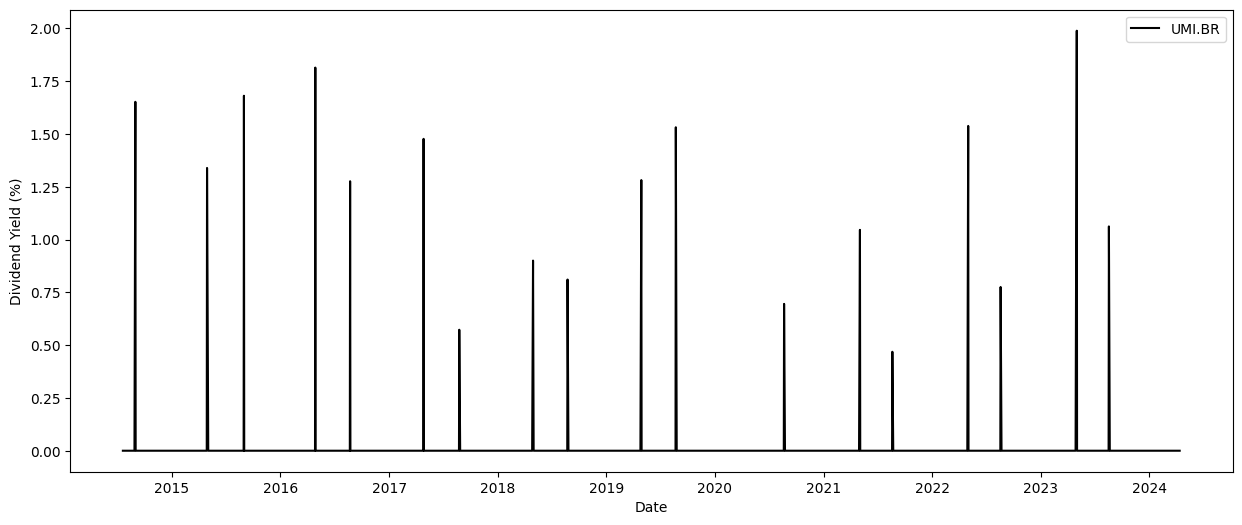

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.190408
share_price      1.000000
Name: share_price, dtype: float64


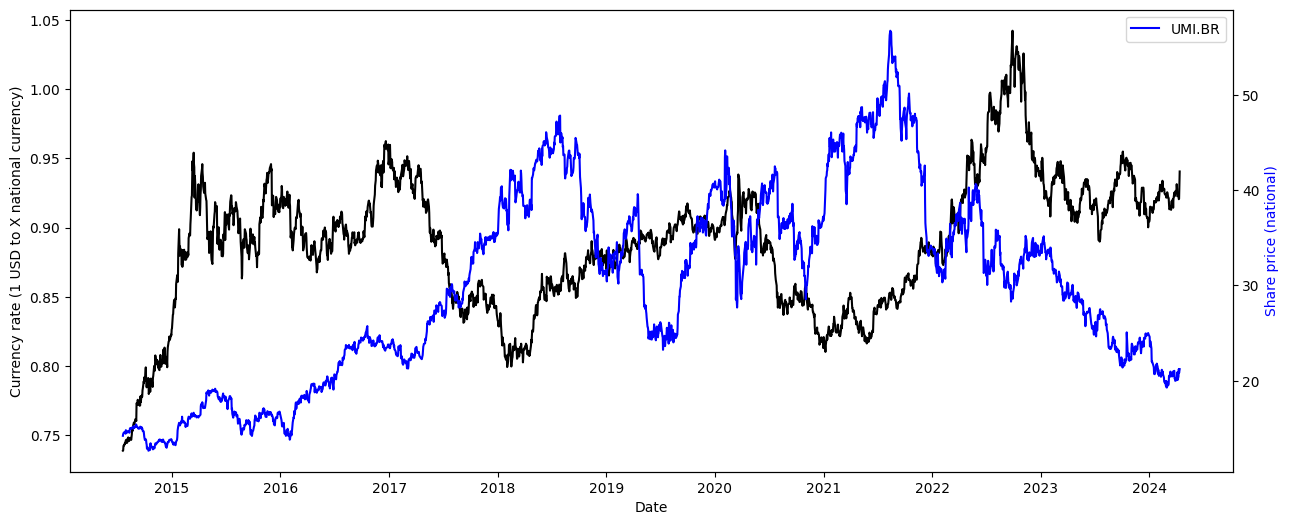

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

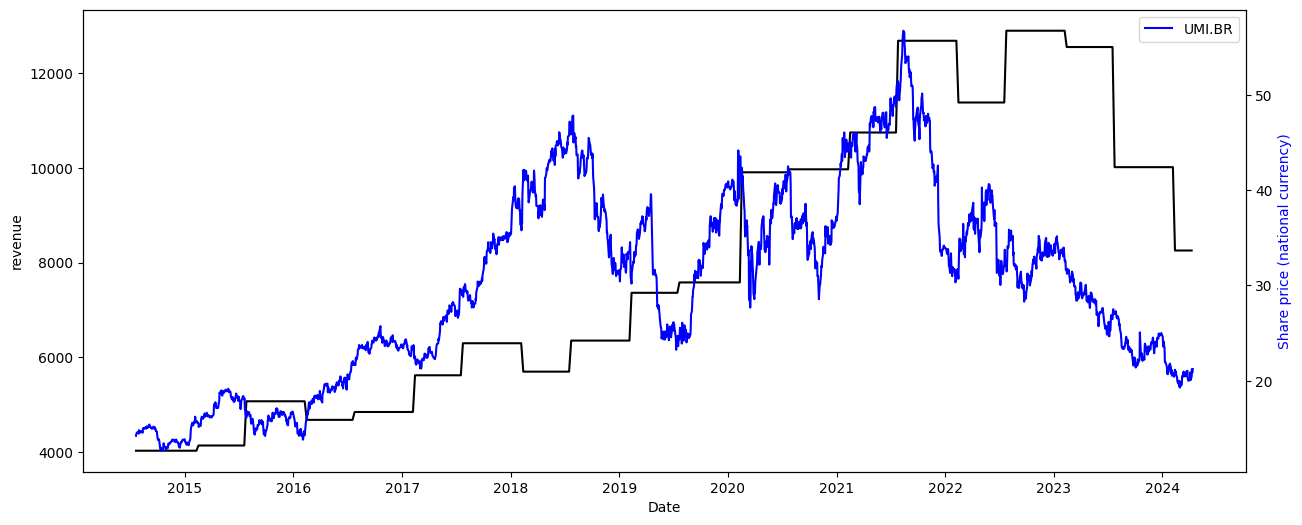

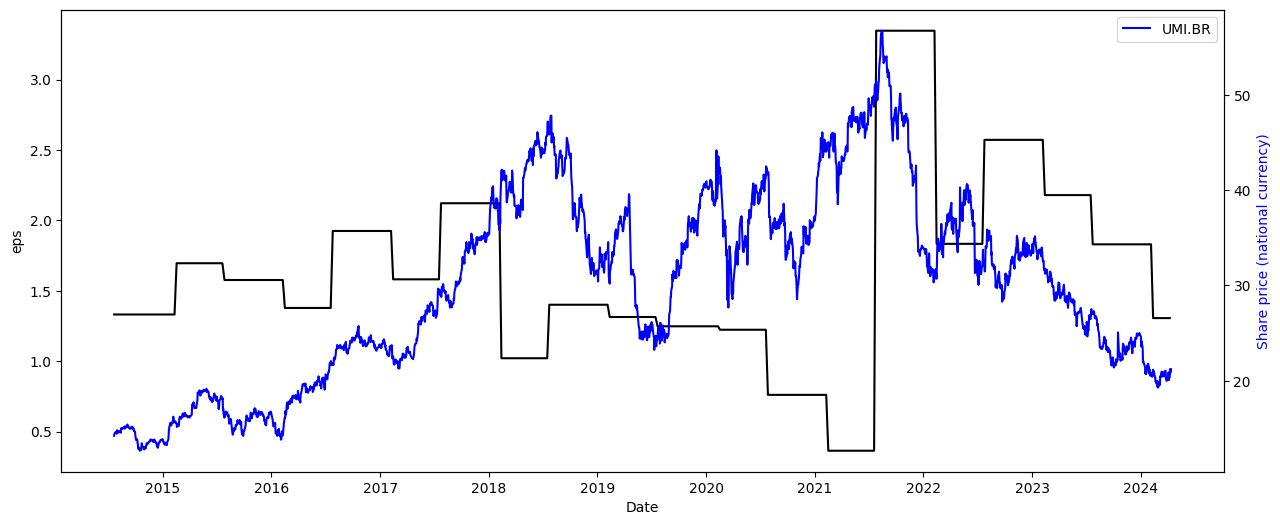

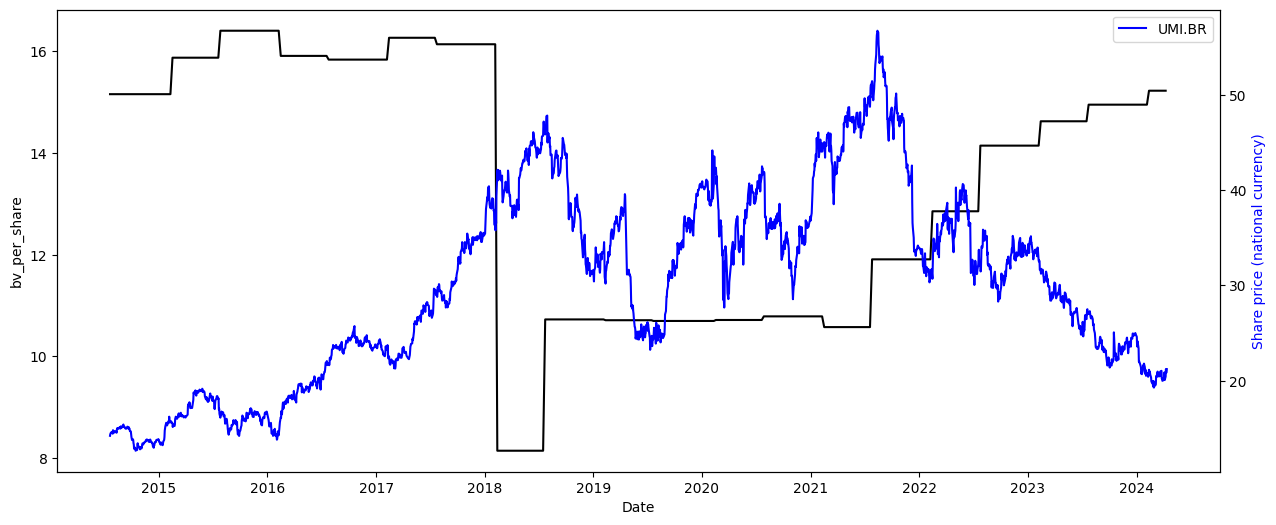

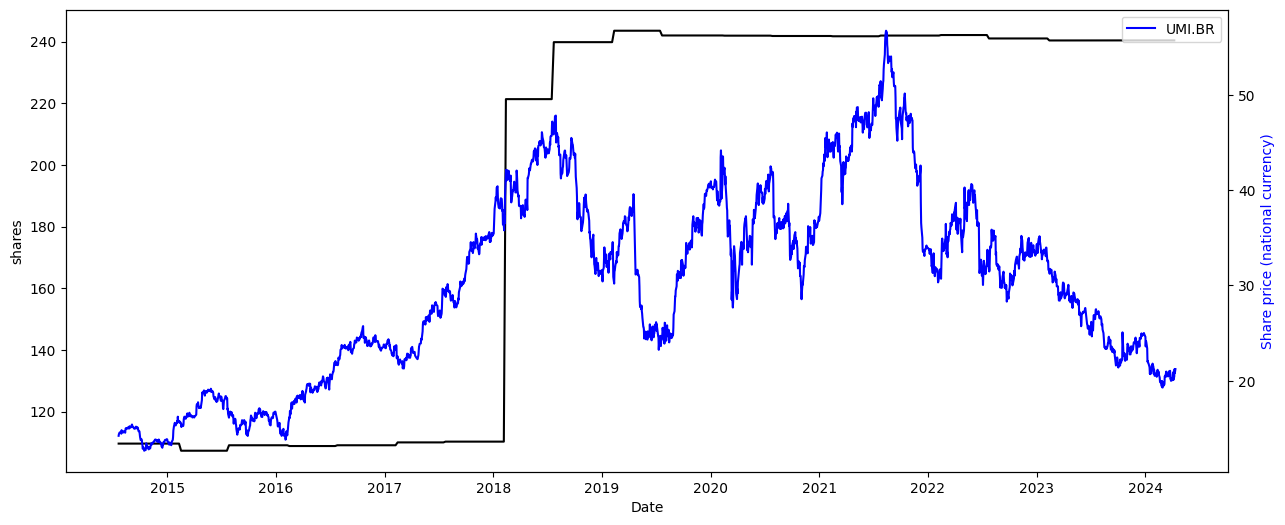

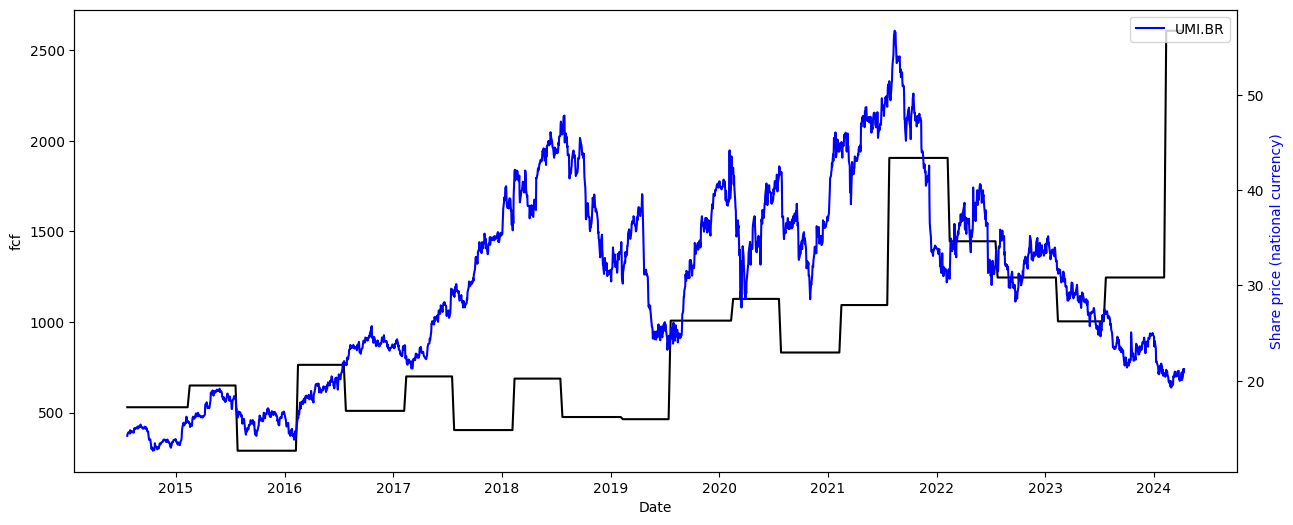

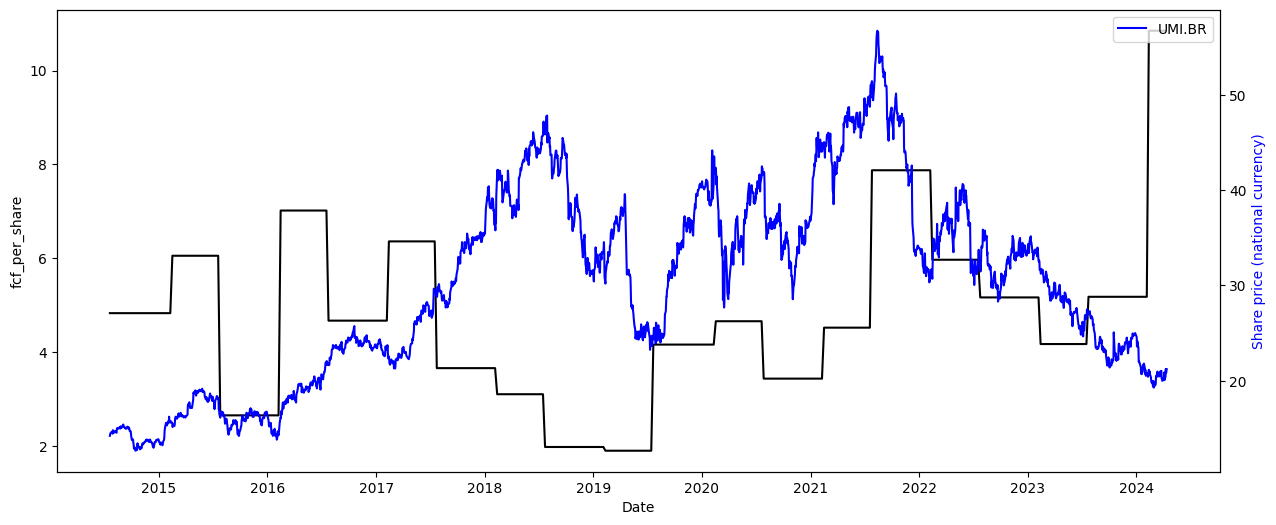

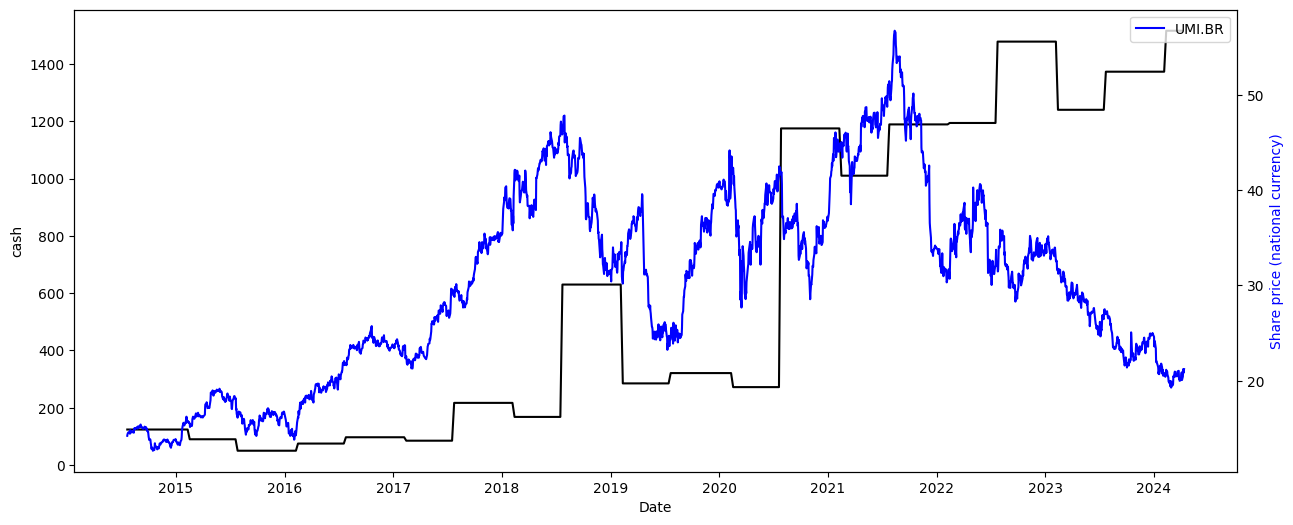

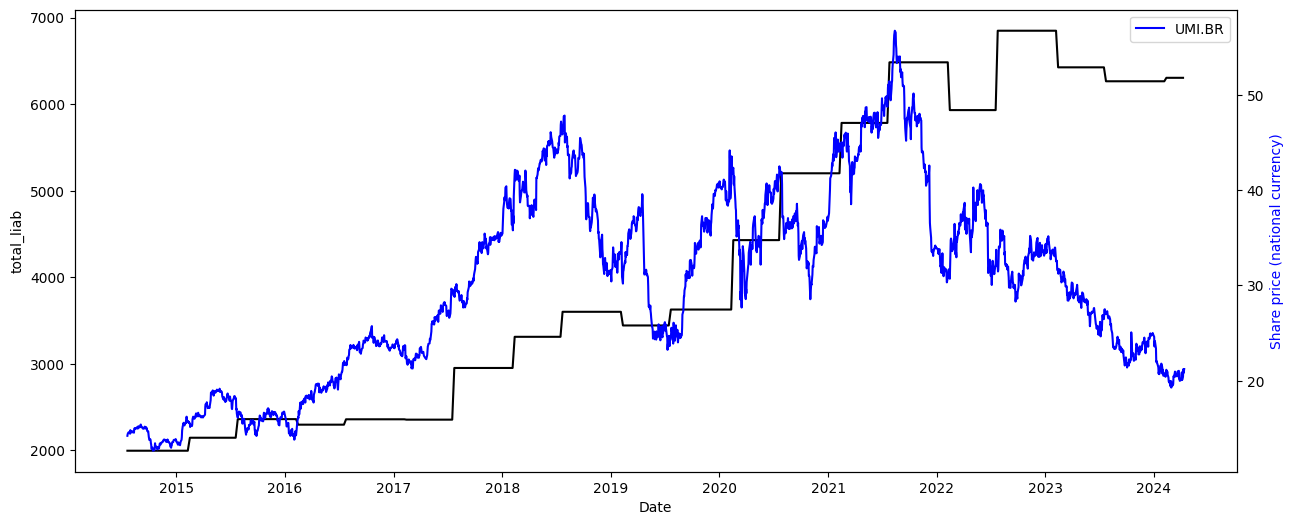

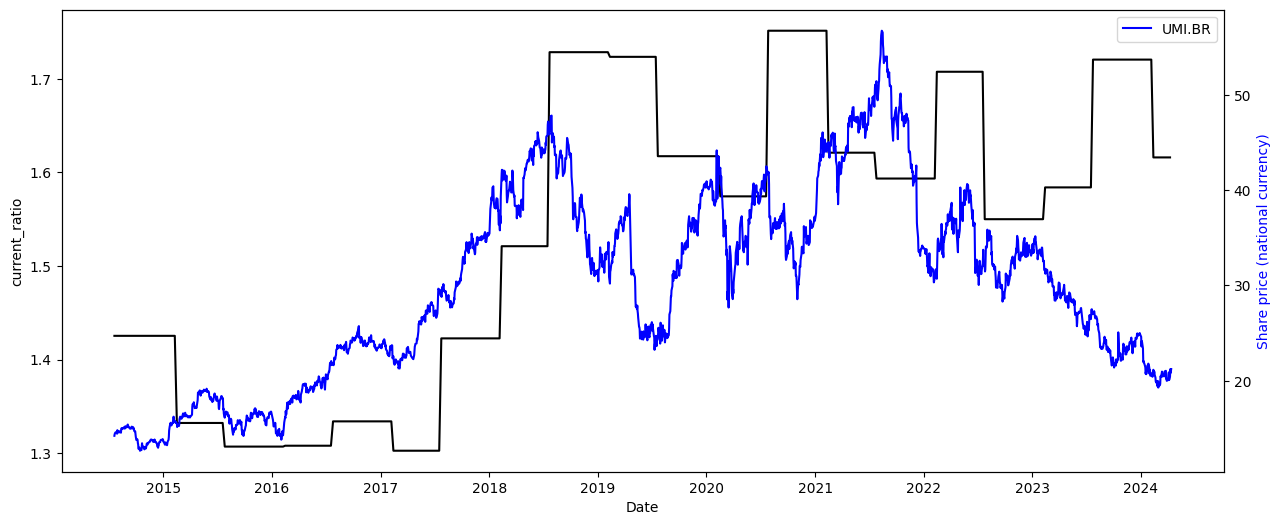

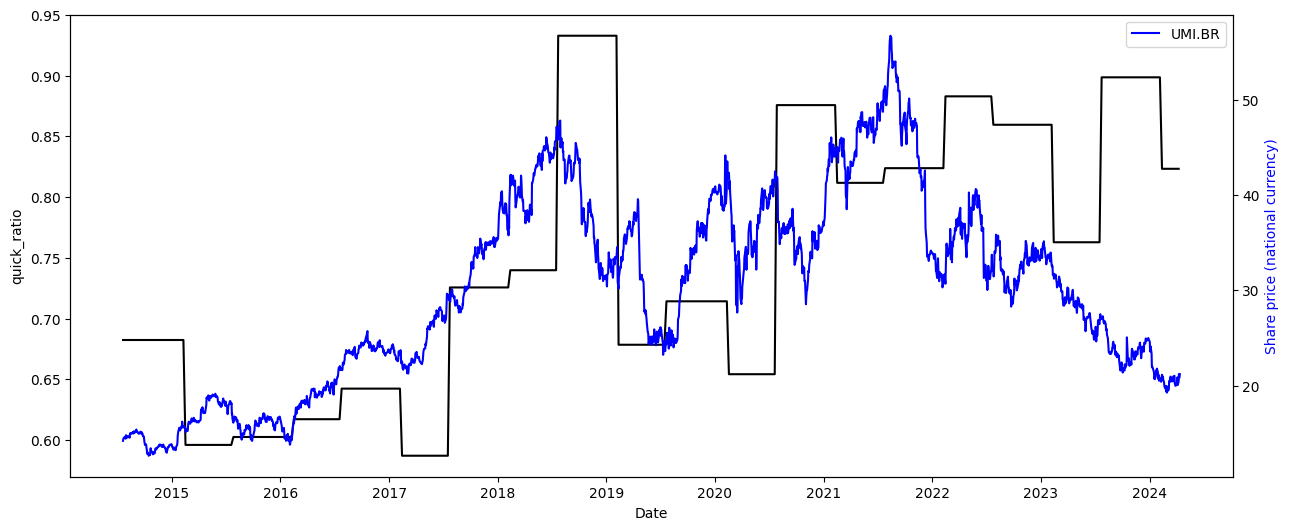

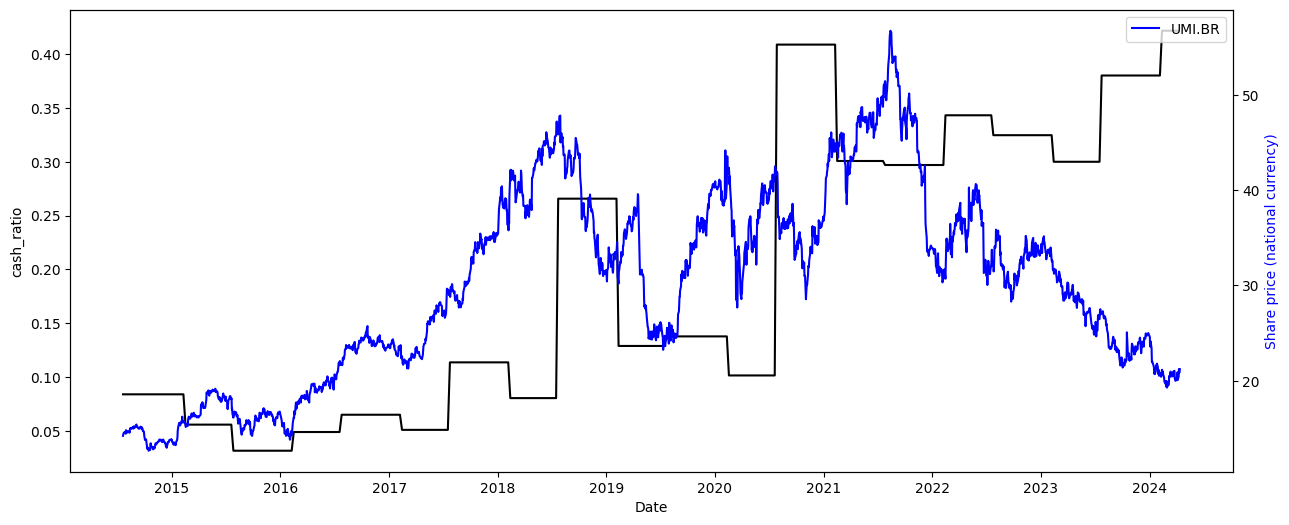

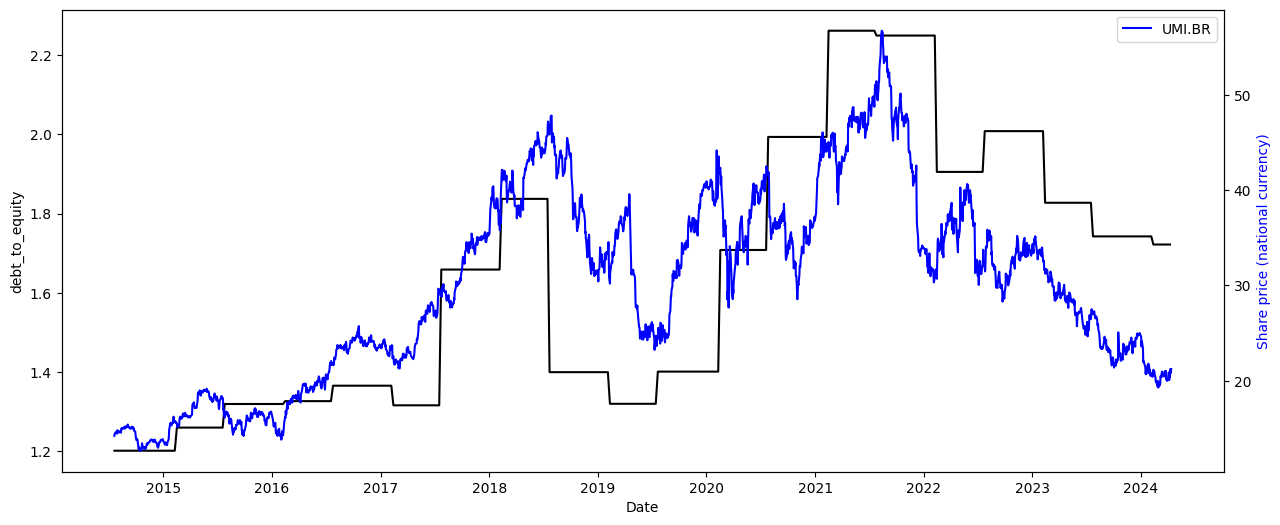

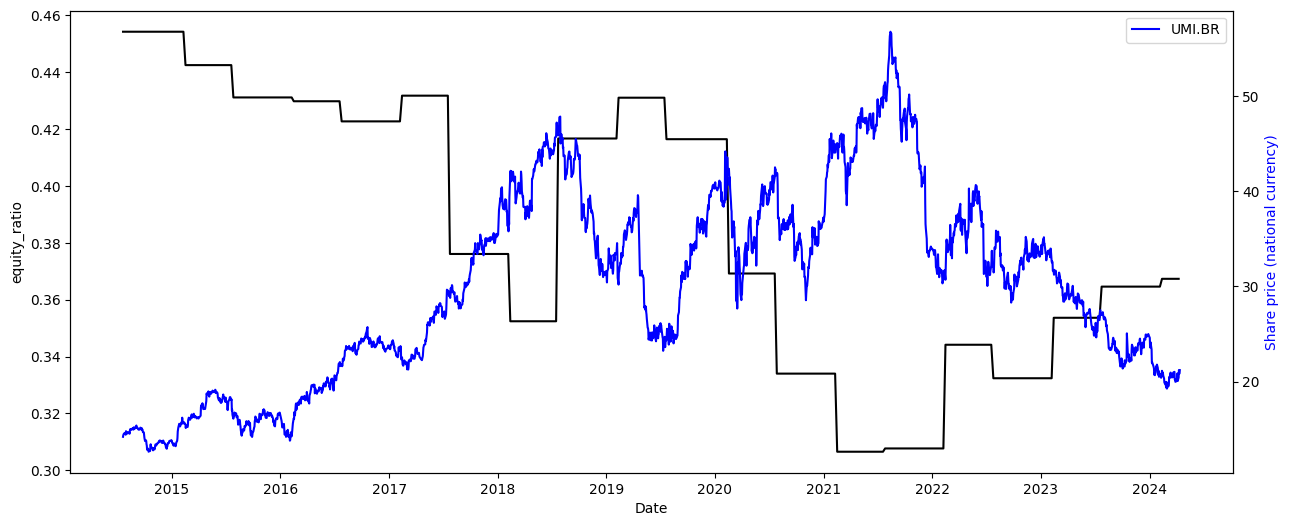

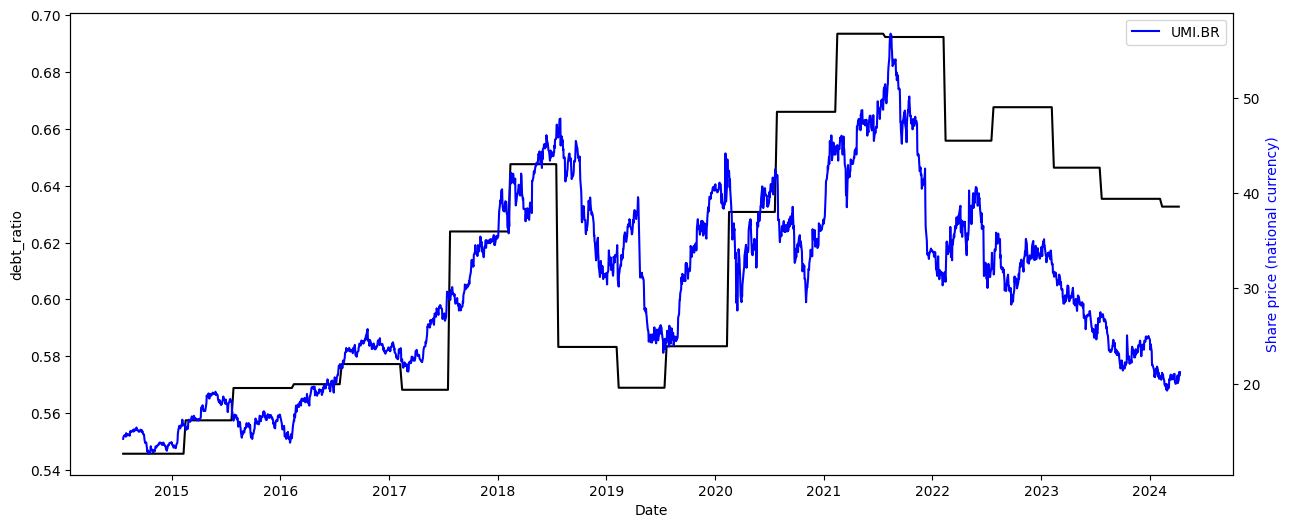

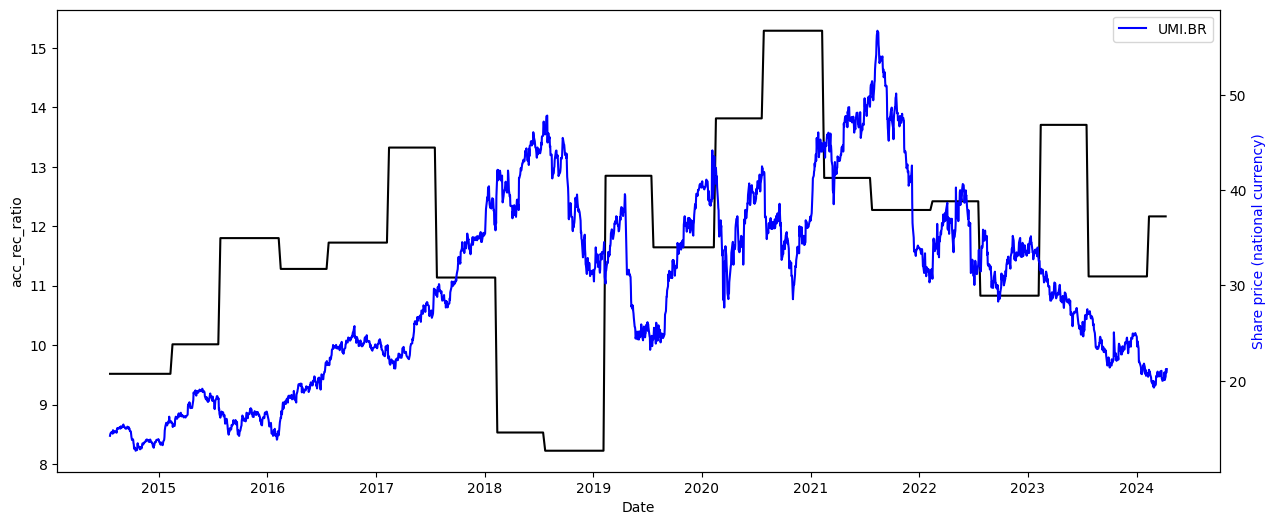

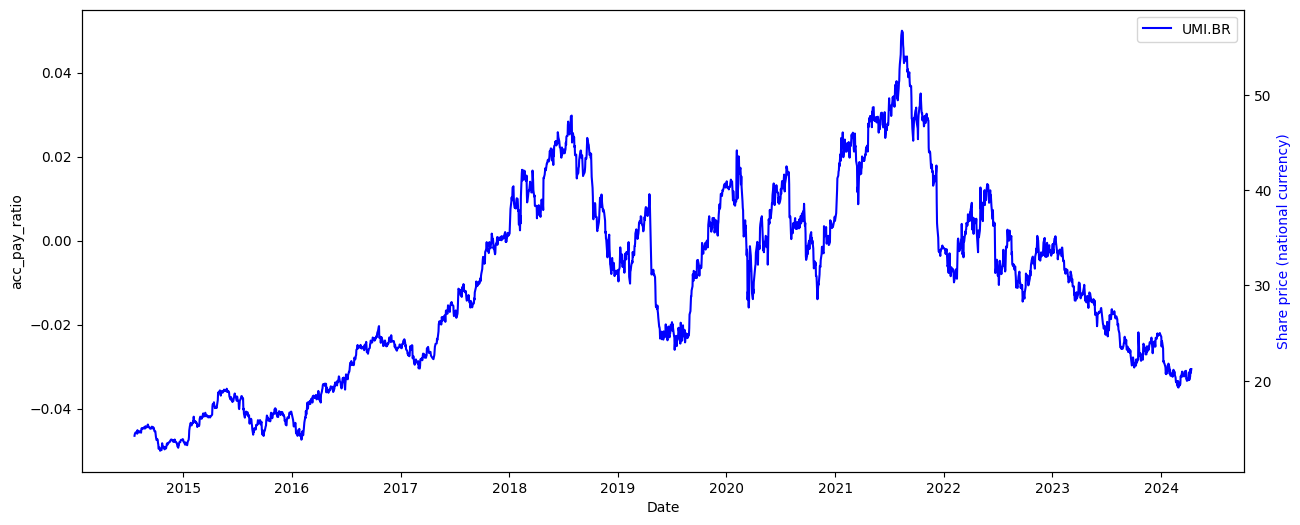

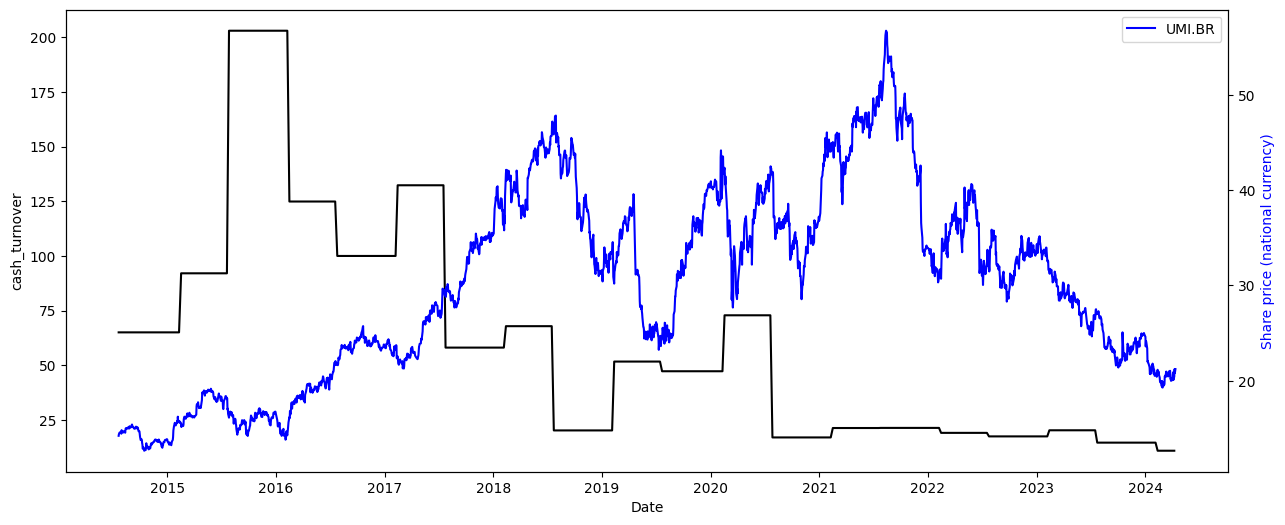

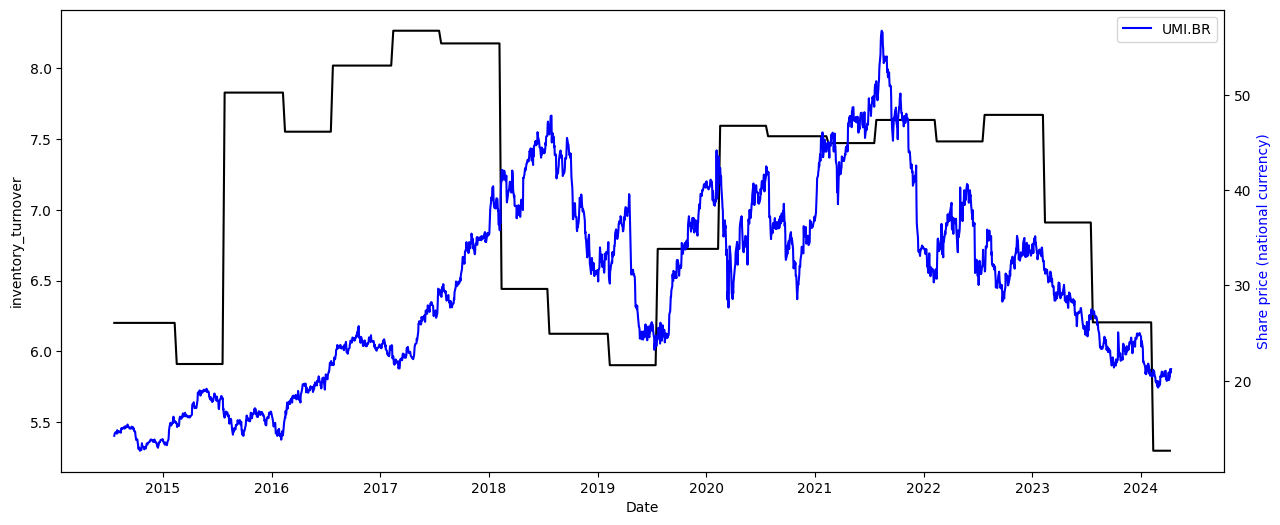

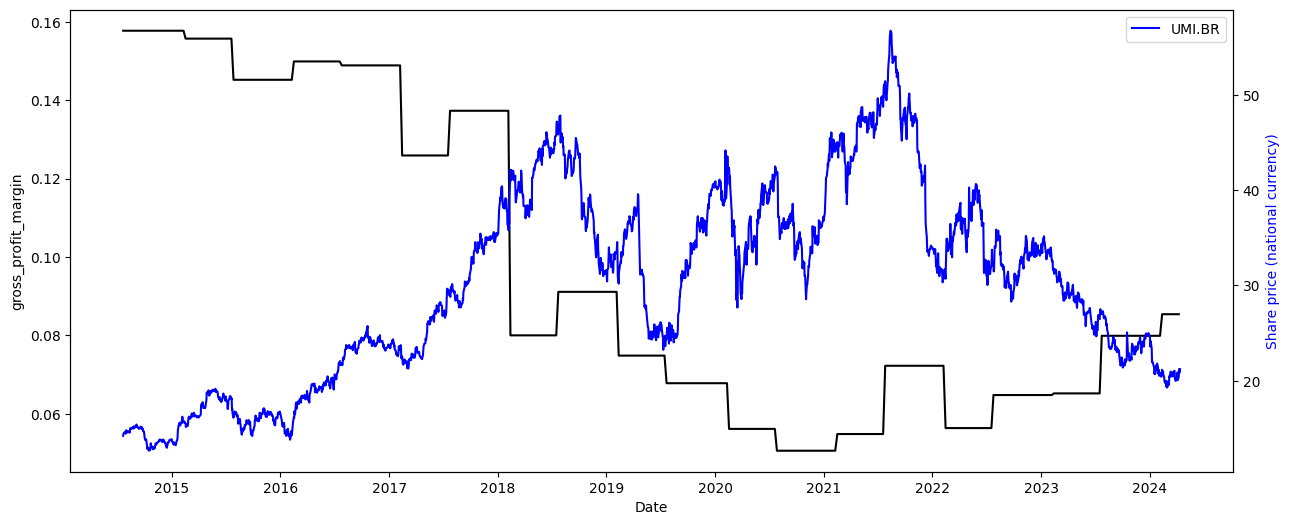

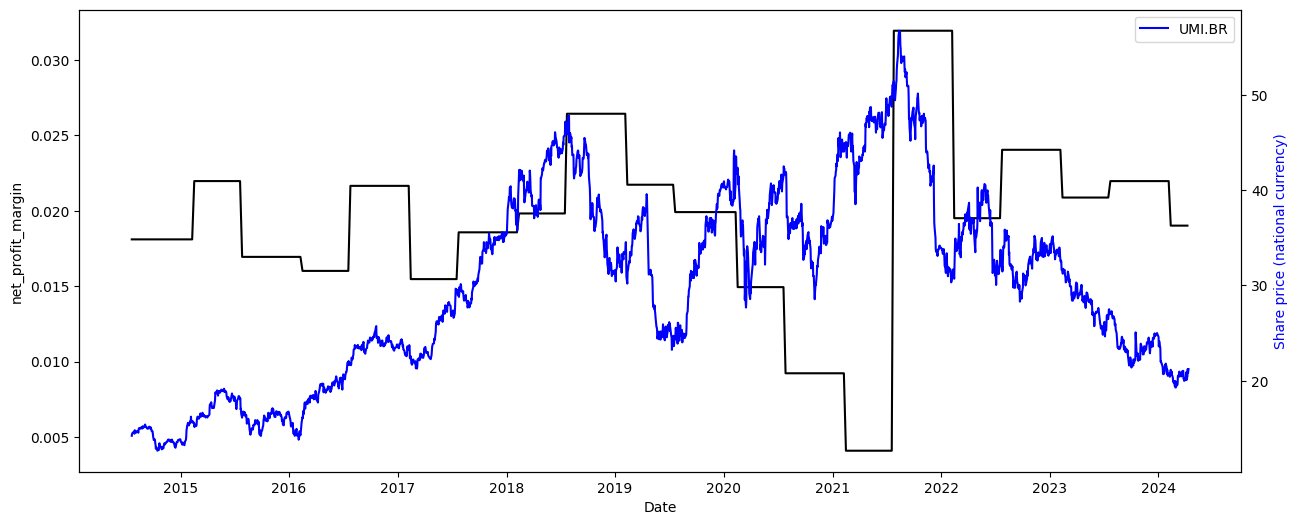

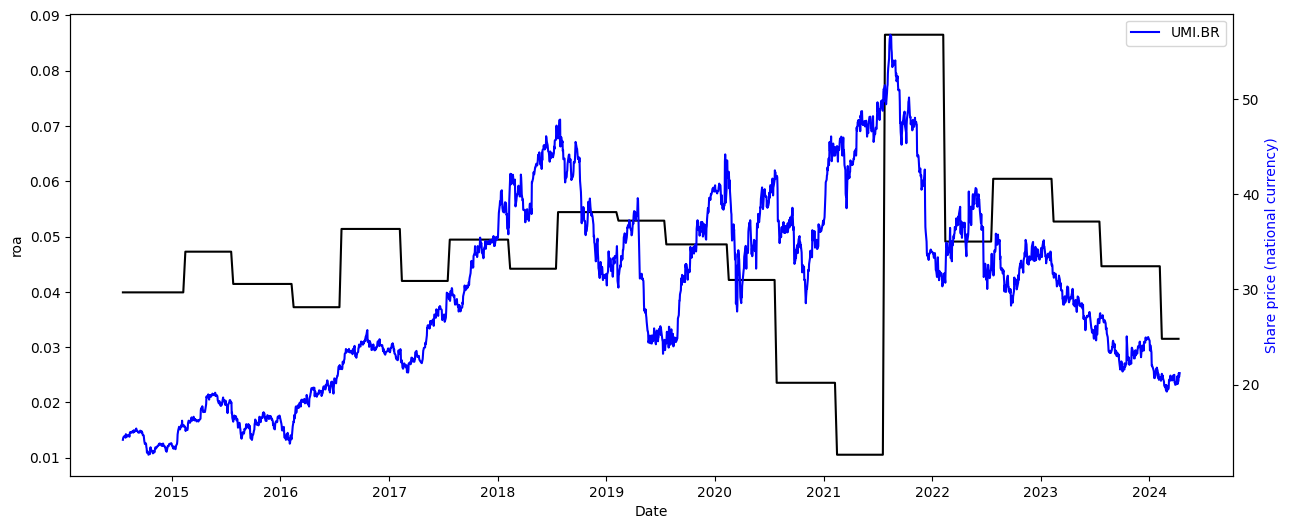

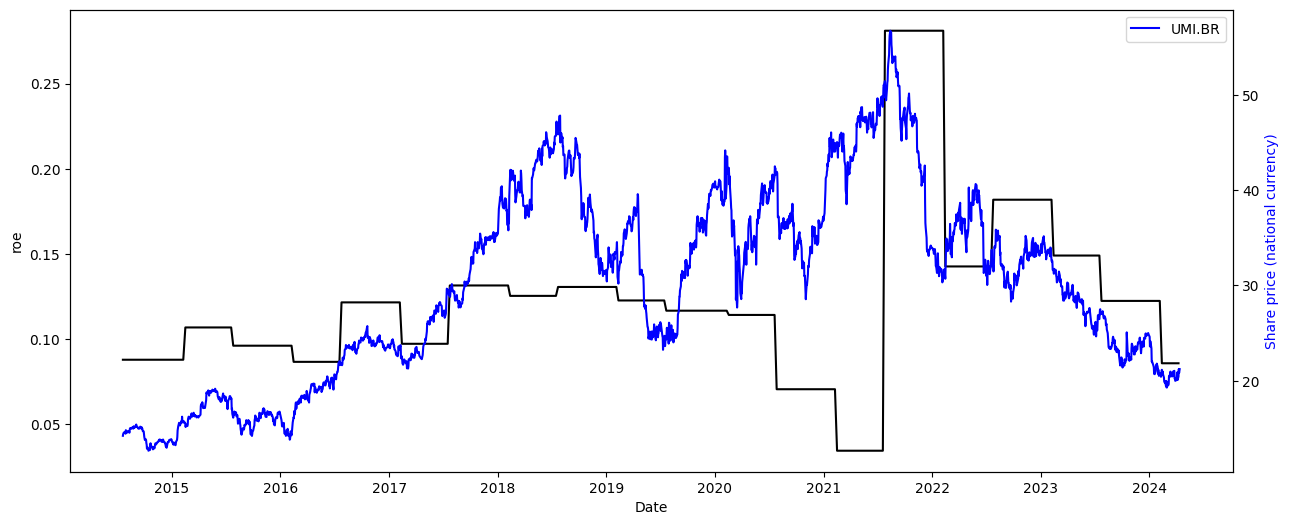

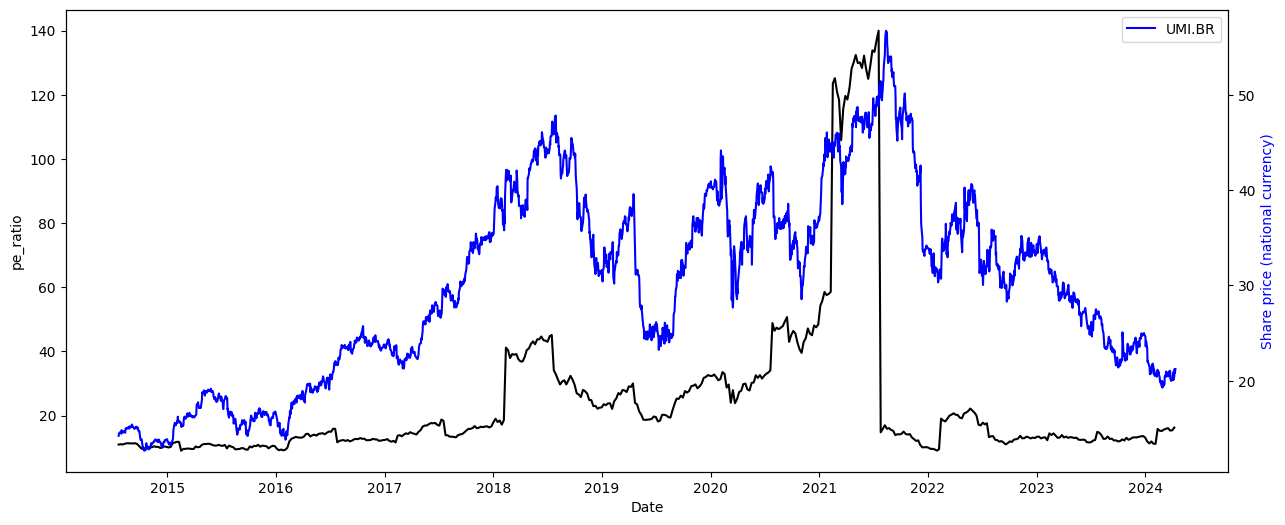

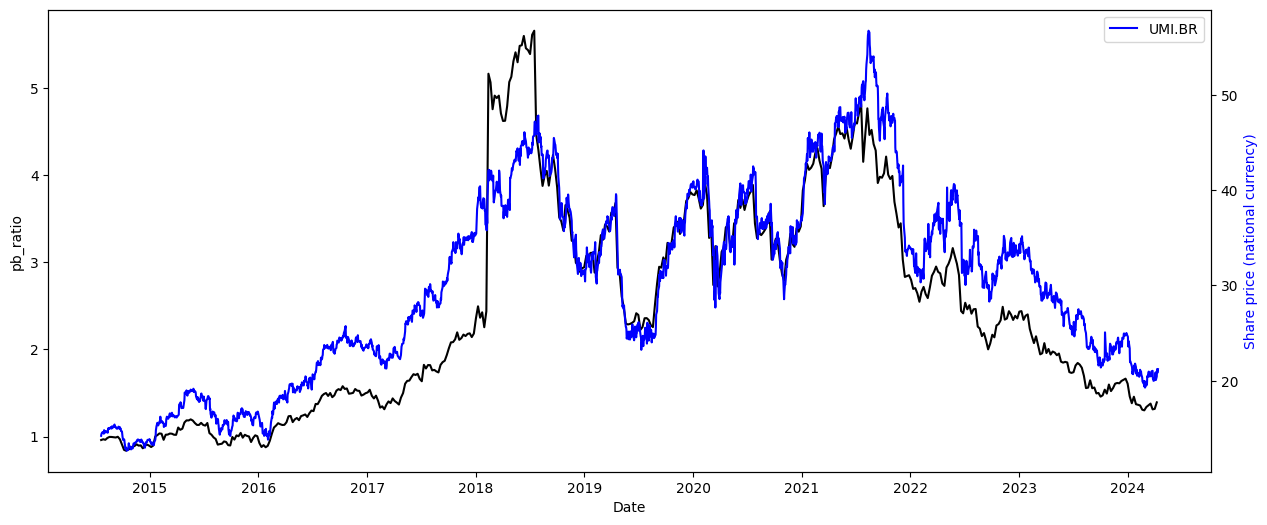

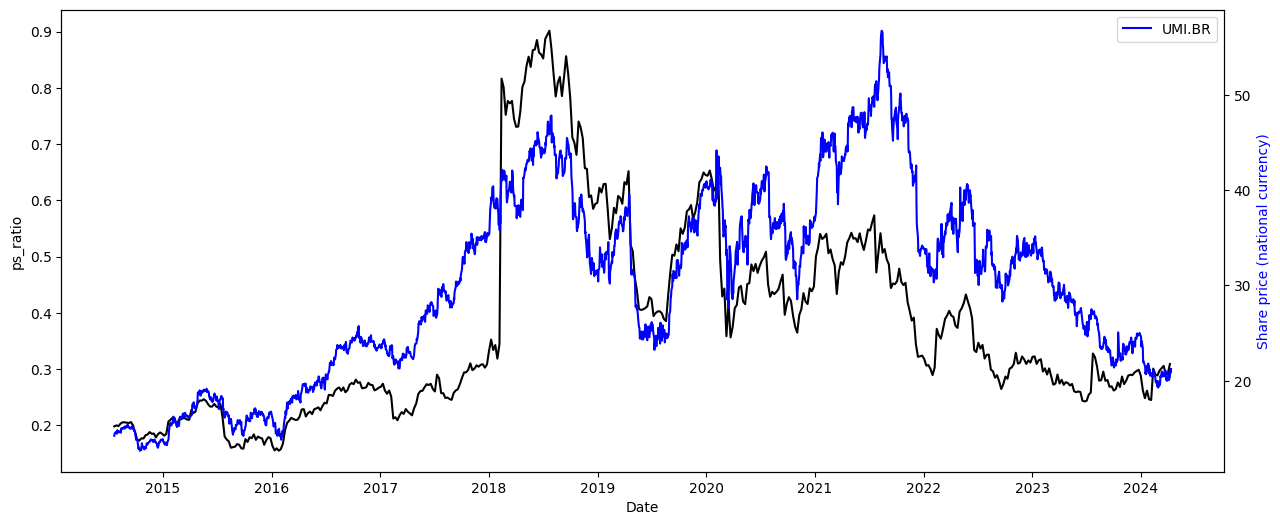

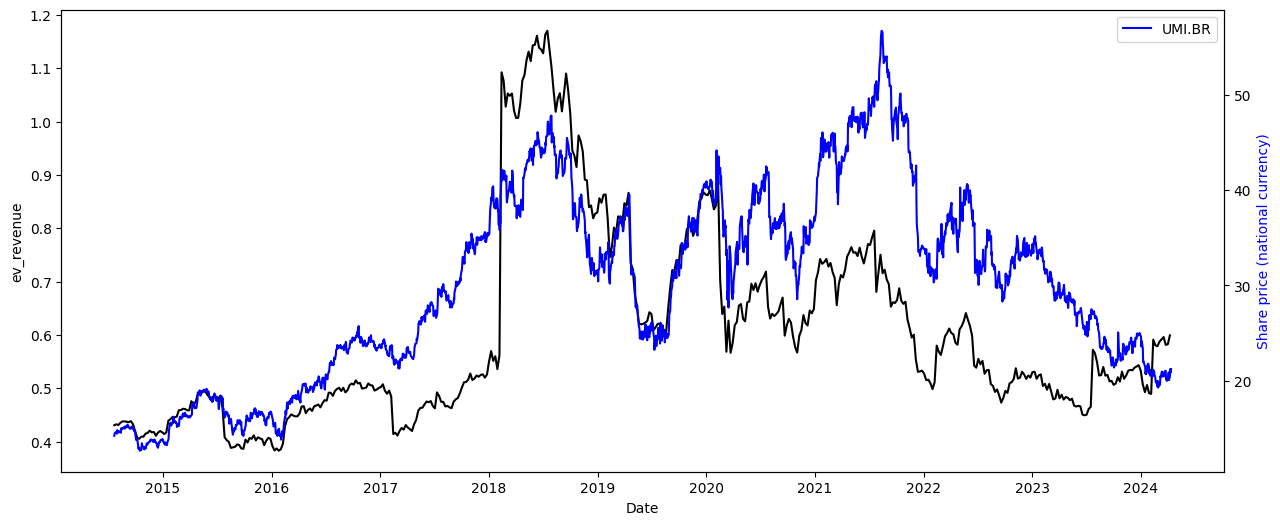

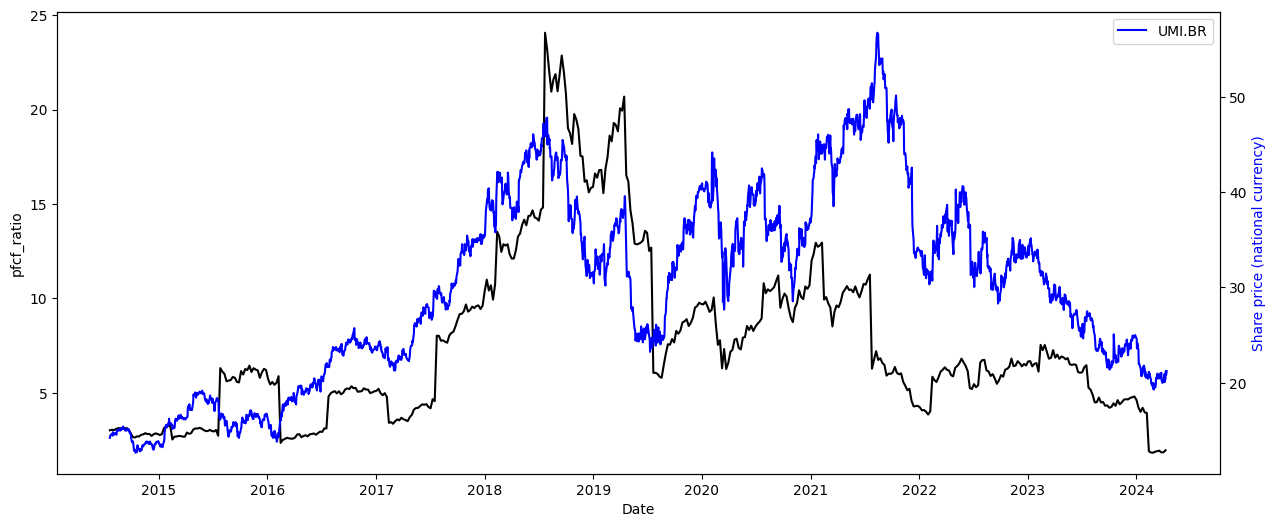

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

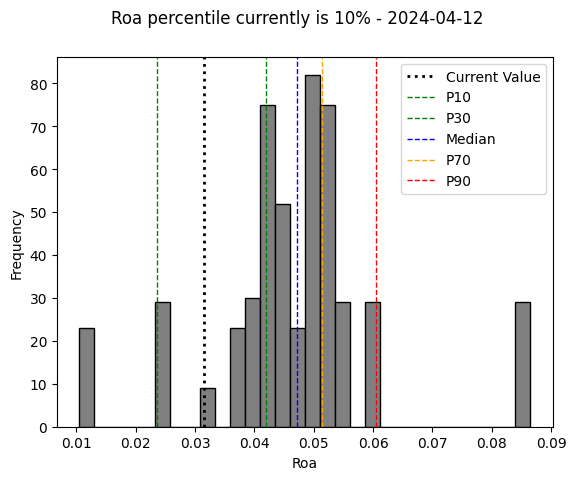

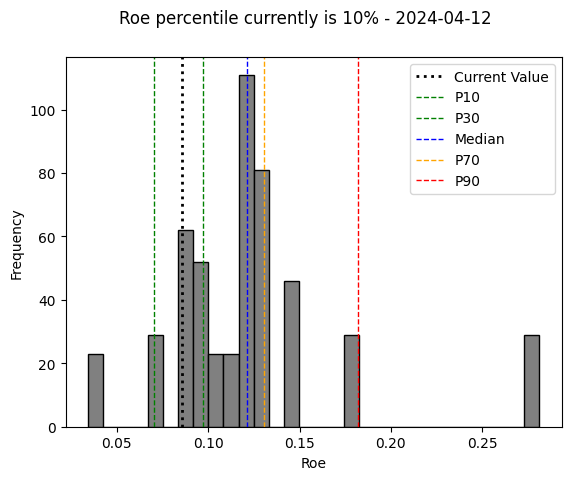

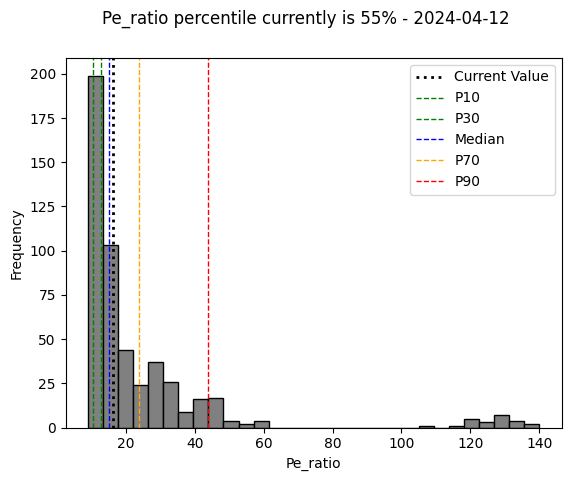

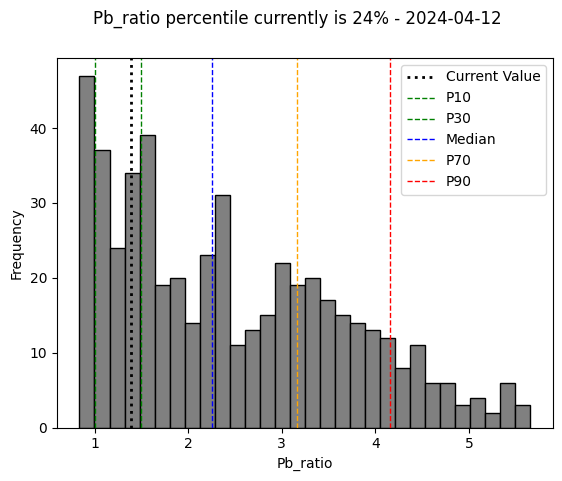

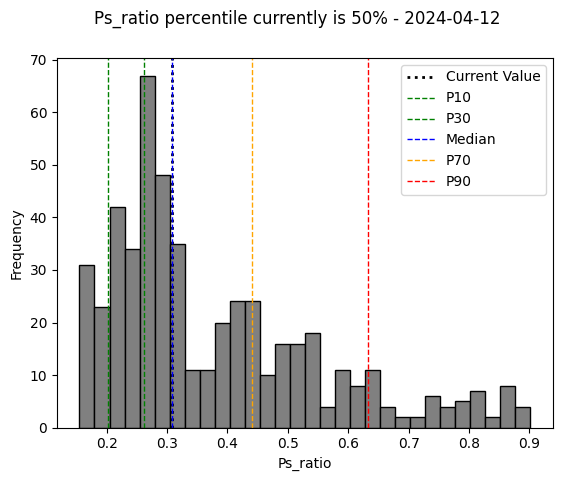

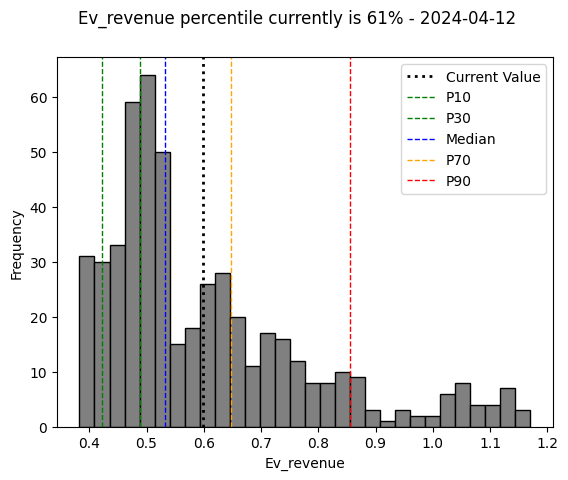

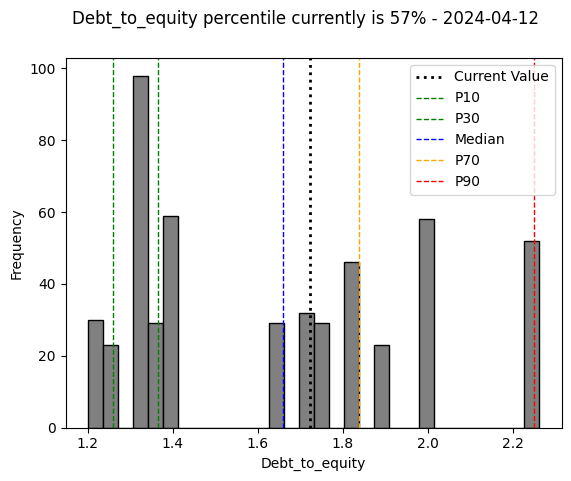

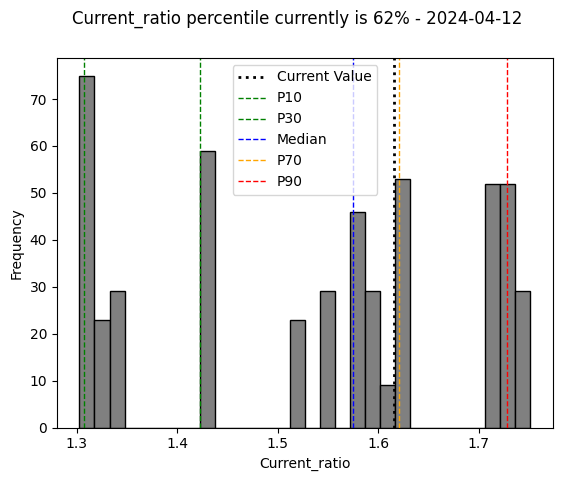

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.948983,-0.619330,0.003217,0.010354,-0.007406,0.076506,0.013179
roe,0.948983,1.000000,-0.451268,0.158444,0.058543,0.032740,0.377593,0.143216
pe_ratio,-0.619330,-0.451268,1.000000,0.627780,0.479998,0.464266,0.474842,0.330423
pb_ratio,0.003217,0.158444,0.627780,1.000000,0.909601,0.882132,0.583174,0.580010
ps_ratio,0.010354,0.058543,0.479998,0.909601,1.000000,0.994195,0.266159,0.565918
ev_revenue,-0.007406,0.032740,0.464266,0.882132,0.994195,1.000000,0.231563,0.532794
debt_to_equity,0.076506,0.377593,0.474842,0.583174,0.266159,0.231563,1.000000,0.512115
current_ratio,0.013179,0.143216,0.330423,0.580010,0.565918,0.532794,0.512115,1.000000


9 timestemos have been found!


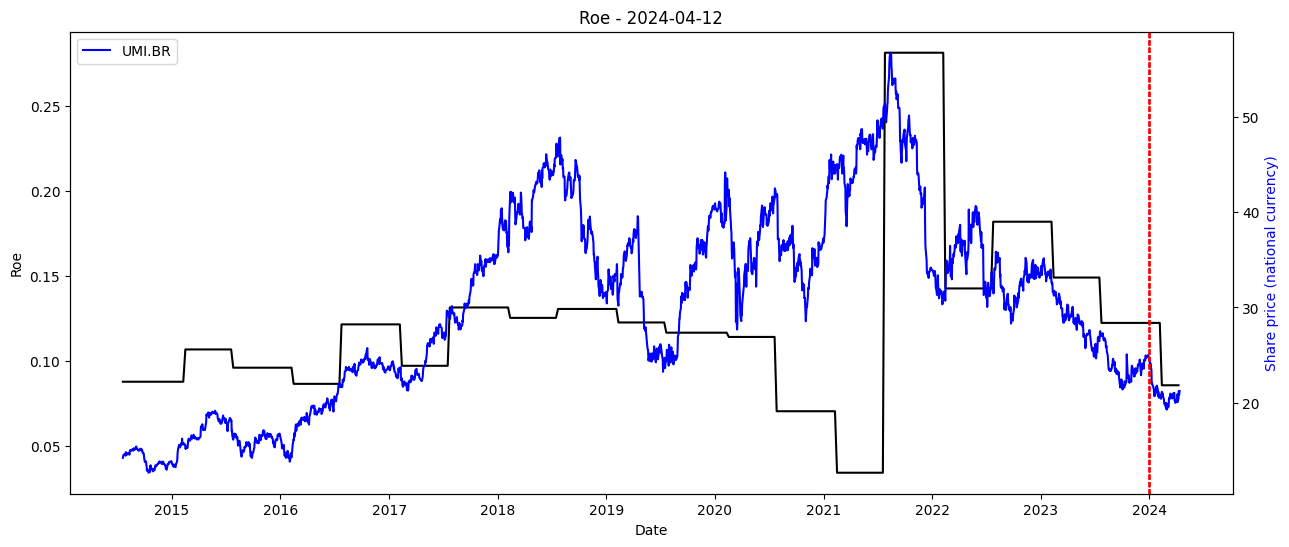

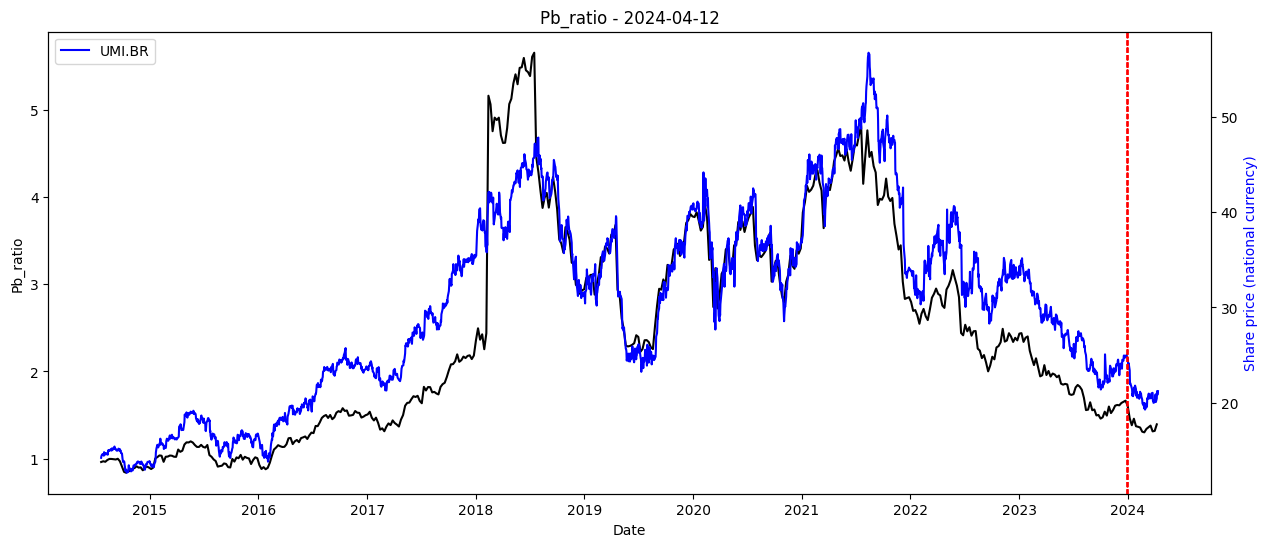

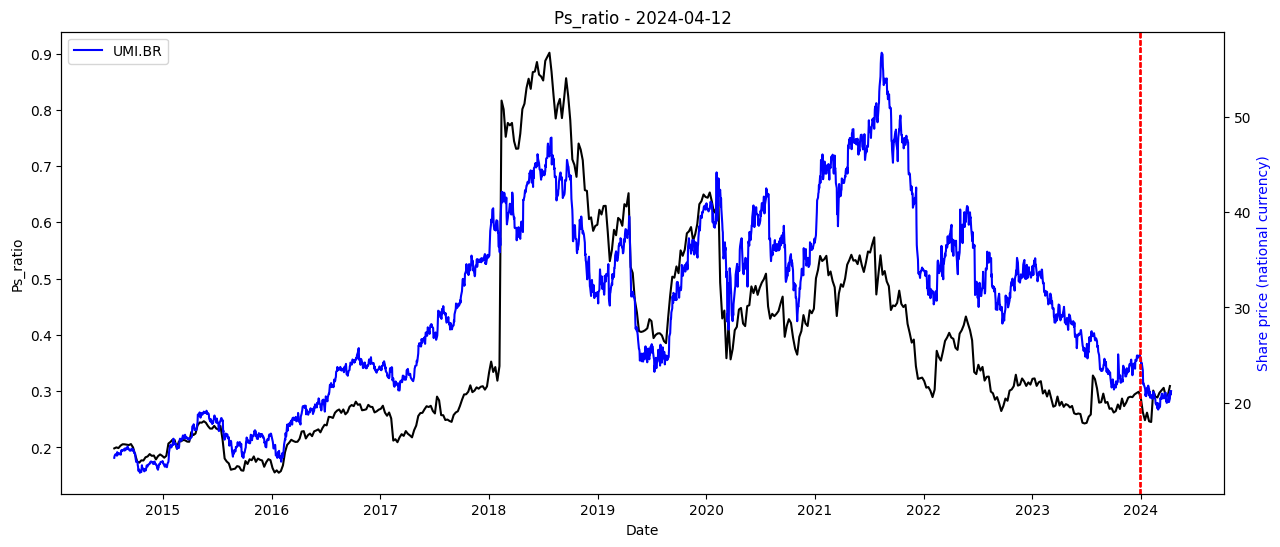

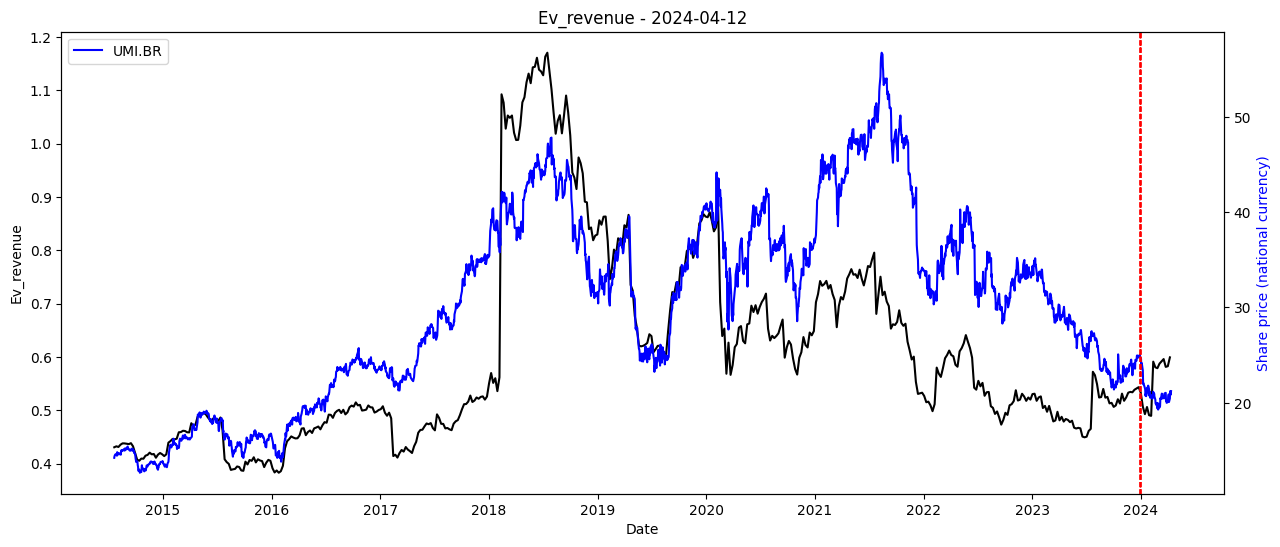

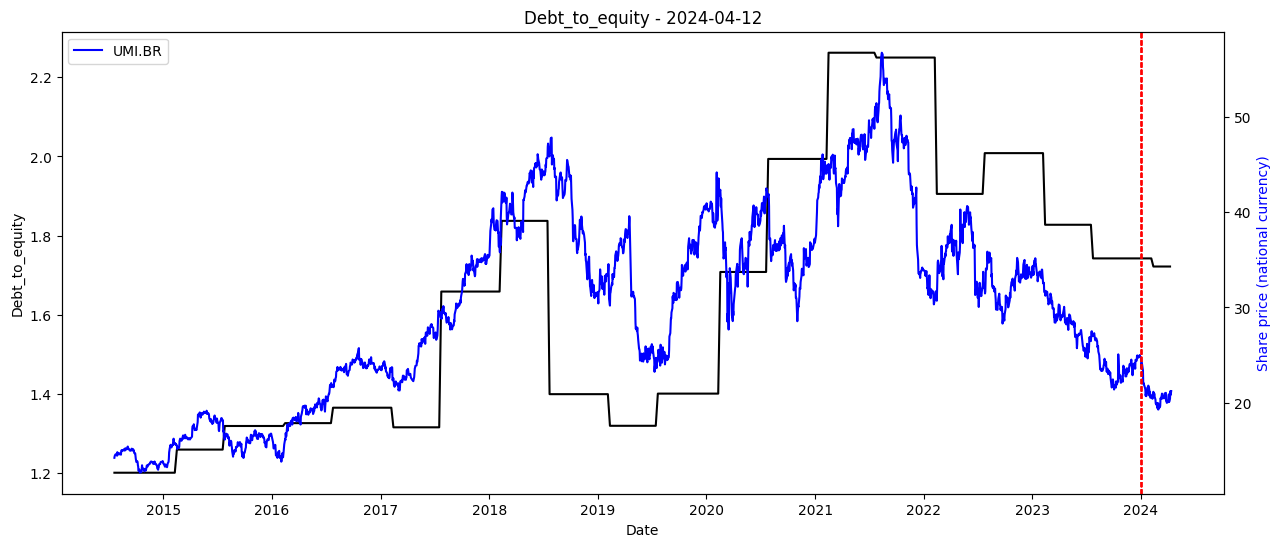

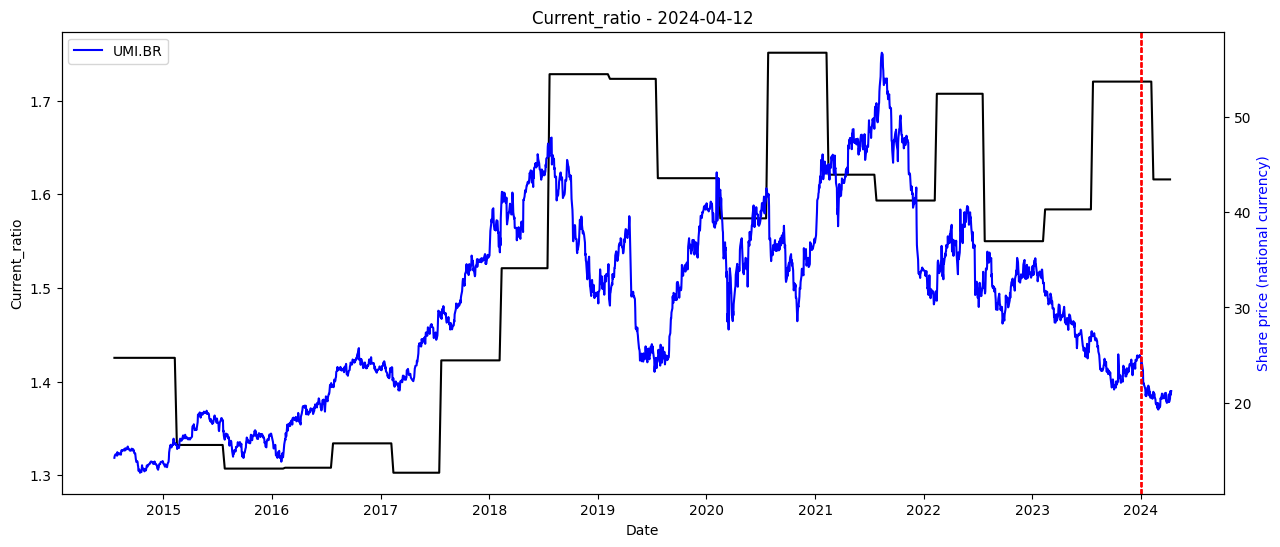

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )